In [1]:
#import packages
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Works Cited
https://www.investopedia.com/terms/e/expectedreturn.asp
https://stackoverflow.com/questions/32752292/how-to-create-a-dataframe-of-random-integers-with-pandas
https://www.w3schools.com/python/ref_func_zip.asp
https://www.youtube.com/watch?v=wlaLmM_LvWg

In [2]:
#select assets and download data

assets = ['TSLA', 'LHX', 'AAPL', 'F', 'BA', 'HD', 'JNJ']
benchmarks = ['SPY', 'DIA', 'IWM']
tickers = assets
start = dt.datetime.today() - dt.timedelta(1095) #1095 for 3  years
data = yf.download(tickers, start= start)['Adj Close']
data = data.dropna(axis=1, how='all')

[*********************100%***********************]  7 of 7 completed


In [3]:
#Asset Vol
data[assets].pct_change(252).std()
asset_volatility = data[assets].pct_change(252).std()
#Daily Return
returns = data[assets].pct_change().dropna()
returns
#Average Asset Return
data[assets].pct_change(252).mean()
asset_return = data[assets].pct_change(252).mean()
asset_return

#Variance & Correlation for matrix
variance = returns.var()
cor = returns.corr()

Ticker      TSLA       LHX      AAPL         F        BA        HD       JNJ
Ticker                                                                      
TSLA    1.000000  0.183404  0.032331  0.668613  0.046576  0.092684  0.083003
LHX     0.183404  1.000000  0.173157  0.084530 -0.577030  0.244051  0.360967
AAPL    0.032331  0.173157  1.000000 -0.020556  0.146192  0.656145 -0.170856
F       0.668613  0.084530 -0.020556  1.000000  0.283318  0.333875 -0.098111
BA      0.046576 -0.577030  0.146192  0.283318  1.000000  0.207023 -0.288818
HD      0.092684  0.244051  0.656145  0.333875  0.207023  1.000000 -0.046334
JNJ     0.083003  0.360967 -0.170856 -0.098111 -0.288818 -0.046334  1.000000


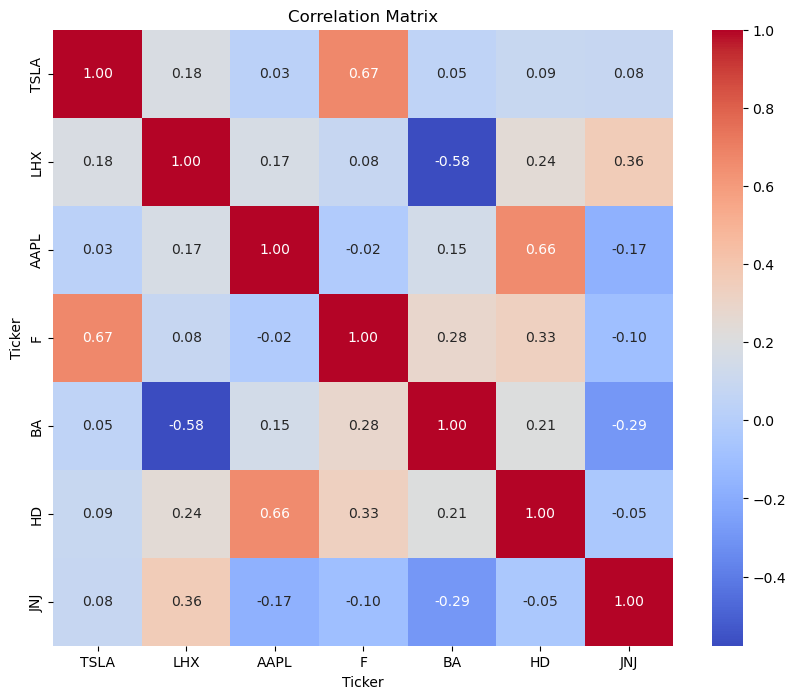

In [4]:
#Create table showing variance, mean, and correlation
table1 = pd.DataFrame(index= assets)
#table1['Weight'] = 1/len(assets)
table1['Volatility'] = asset_volatility
table1['Annualized Asset Return'] = asset_return
#table1['Expected Rate of Return'] = table1['Annualized Asset Return'] *table1['Weight']*100 https://finance.yahoo.com/news/calculating-expected-return-portfolio-203846984.html
table1['Annualized Asset Return'] = asset_return
table1['Variance'] = returns.var() 


table1



matrix = data[assets].corr() #https://stackoverflow.com/questions/59687643/correlation-on-python
print(matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

TSLA:0.01525
LHX:0.06902
AAPL:0.40161
F:0.02459
BA:0.33837
HD:0.14499
JNJ:0.00618
Optimal portfolio:
Annualized Return: 24.28
Annualized Volatility: 11.75

Optimal weights:


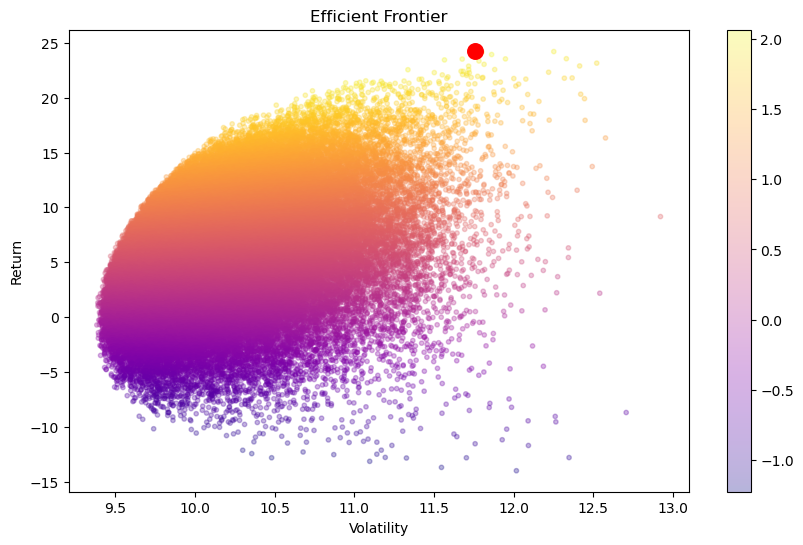

In [8]:
#Monte Carlo
def portfolio_annualized_performance(weights, asset_return, cov_matrix):
    returns = np.sum(asset_return * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, asset_return, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, asset_return, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

#number of iterations
num_portfolios = 100000
#government set
risk_free_rate = 0.01
results, weights = random_portfolios(num_portfolios, asset_return, cor, risk_free_rate)


#calculate the efficient frontier using Monte Carlo method
def efficient_frontier(returns, cov_matrix, risk_free_rate):
    args = (returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(assets)))
    
efficient_portfolios = []
target_returns = np.linspace(returns.mean().min(), returns.mean().max(), 100)



#calculate the maximum sharpe
max_sharpe_idx = np.argmax(results[2])
sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

#plot
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='plasma', s=10, alpha=0.3)
plt.colorbar()
plt.scatter(sdp, rp, marker='.', color='r', s=500, label='Maximum Sharpe ratio')
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title('Efficient Frontier')

#https://www.w3schools.com/python/ref_func_zip.asp
for a, w in zip(assets, weights[max_sharpe_idx]):
    print(f'{a}:{w:.5f}')

print("Optimal portfolio:")
print("Annualized Return:", round(rp, 2))
print("Annualized Volatility:", round(sdp, 2))
print("\nOptimal weights:")
